Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages('forecast')


In [ ]:
overdisp_fun <- function(model) {
    rdf<- df.residual(model)
    rp <- residuals(model,type="pearson")
    Pearson.chisq <- sum(rp^2)
    prat <- Pearson.chisq/rdf
    pval <- pchisq(Pearson.chisq, df=rdf, lower.tail=FALSE)
    c(chisq=Pearson.chisq,ratio=prat,rdf=rdf,p=pval)
}

Loading required package: nlme

This is mgcv 1.8-38. For overview type 'help("mgcv-package")'.



[1] "data"                                  
 [2] "stato"                                 
 [3] "codice_regione"                        
 [4] "denominazione_regione"                 
 [5] "lat"                                   
 [6] "long"                                  
 [7] "ricoverati_con_sintomi"                
 [8] "terapia_intensiva"                     
 [9] "totale_ospedalizzati"                  
[10] "isolamento_domiciliare"                
[11] "totale_positivi"                       
[12] "variazione_totale_positivi"            
[13] "nuovi_positivi"                        
[14] "dimessi_guariti"                       
[15] "deceduti"                              
[16] "casi_da_sospetto_diagnostico"          
[17] "casi_da_screening"                     
[18] "totale_casi"                           
[19] "tamponi"                               
[20] "casi_testati"                          
[21] "note"                                  
[22] "ingressi_terapia_intensiva"            
[23] "note_test"                             
[24] "note_casi"                             
[25] "totale_positivi_test_molecolare"       
[26] "totale_positivi_test_antigenico_rapido"
[27] "tamponi_test_molecolare"               
[28] "tamponi_test_antigenico_rapido"        
[29] "codice_nuts_1"                         
[30] "codice_nuts_2"


Family: poisson 
Link function: log 

Formula:
ic ~ s(h, bs = "ps", k = 7)

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) 4.908681   0.008856   554.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
       edf Ref.df Chi.sq p-value    
s(h) 4.141  4.601   4205  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.979   Deviance explained = 98.4%
-REML =  477.6  Scale est. = 1         n = 124

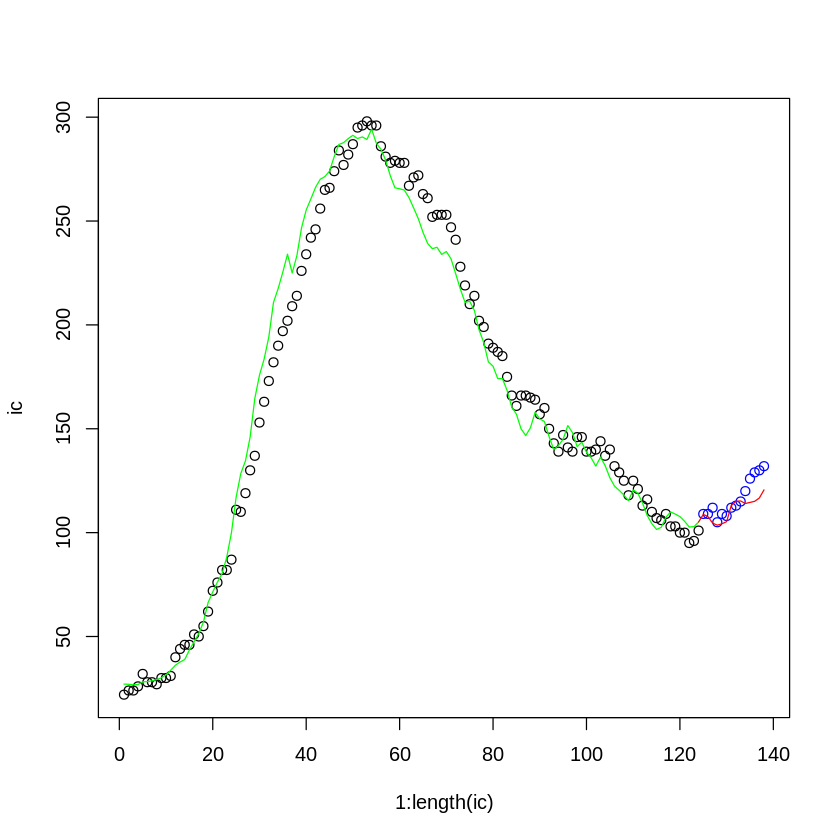

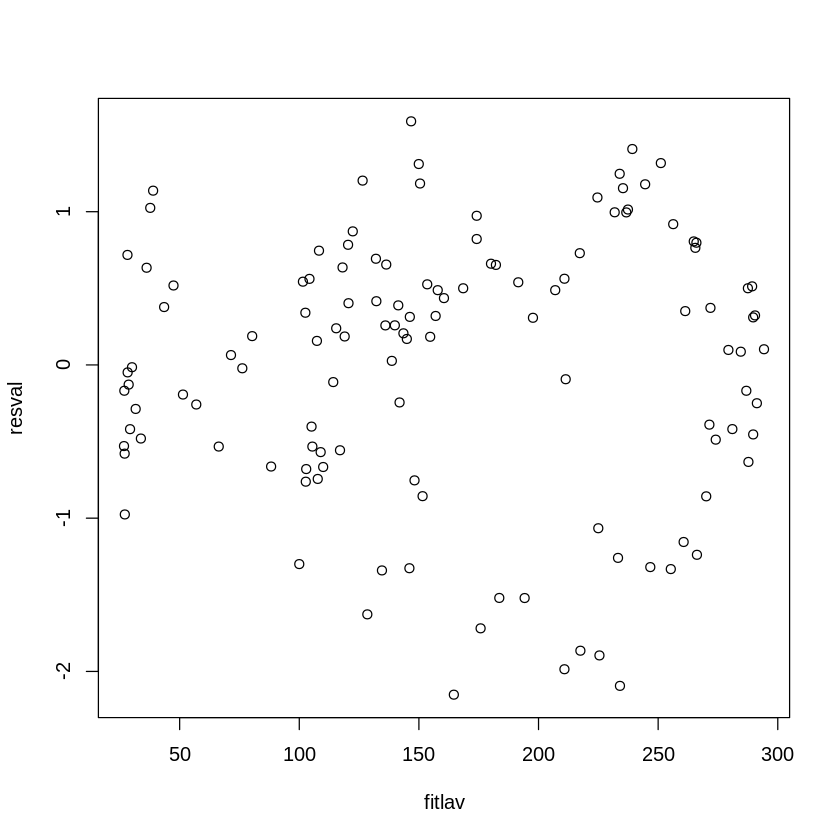

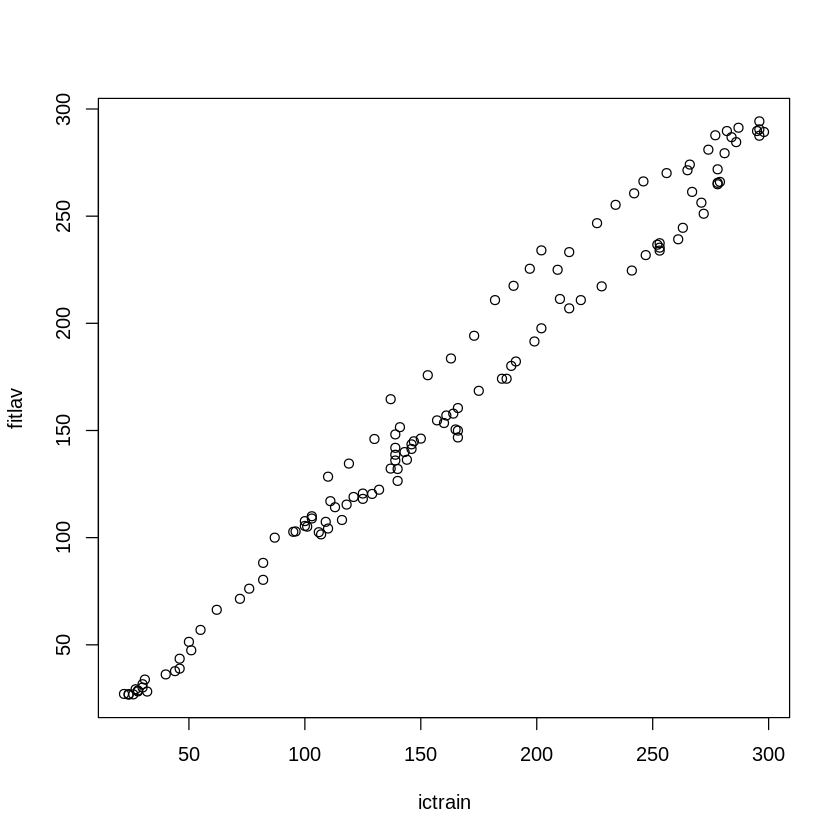

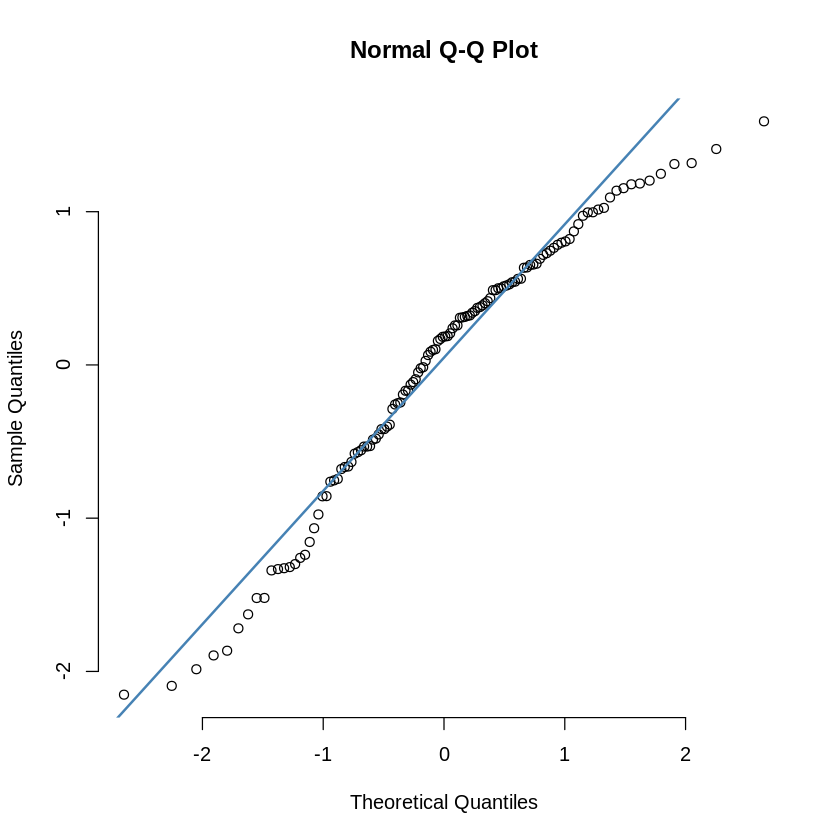

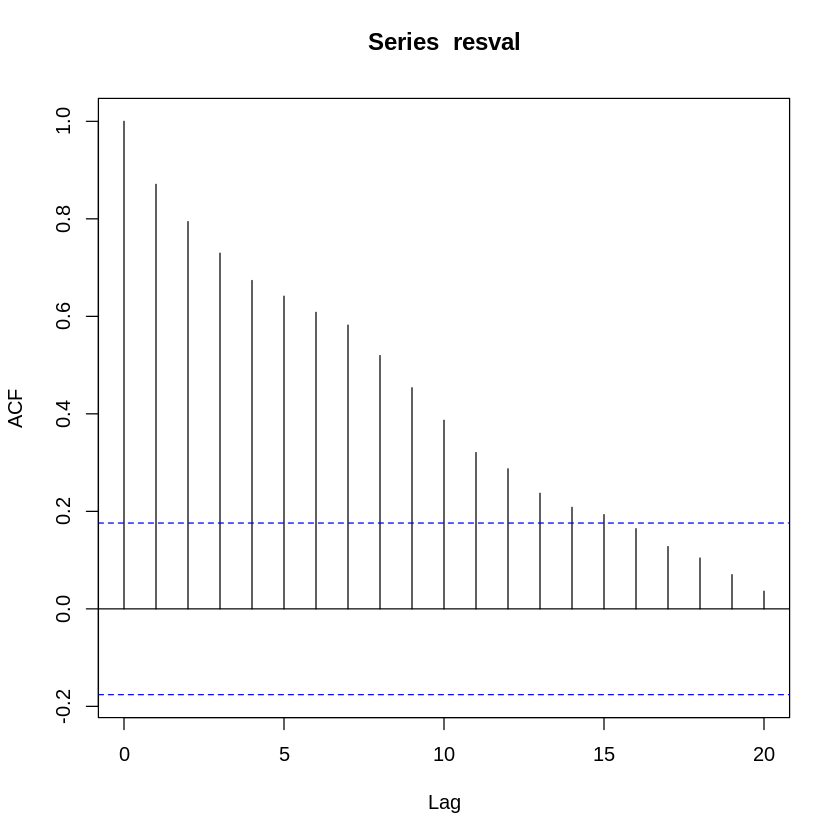

In [12]:
#gam without epidemic separation (quasipoisson)
library('mgcv')
data<-read.csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv")
data<-data[data$denominazione_regione=="Toscana",]
datatrain<-data[221:344,]
datatest<-data[345:358,]
ictest<-datatest[,8]
ictrain=datatrain[,8]
htest<-datatest[,9]
htrain=datatrain[,9]
timetrain<-1:length(ictrain)
timetest<-(timetrain[length(timetrain)]+1):(timetrain[length(timetrain)]+length(ictest))
newdatatrain=data.frame(h=htrain,ic=ictrain)
newdatatest=data.frame(h=htest,ic=ictest)
m3 <- gam(ic ~ s(h, bs="ps", k=7), family='poisson',data=newdatatrain,method = "REML")
summary(m3)
icpred=predict(m3,newdata=newdatatest,type="response")
#plot(1:length(postrain),newpostrain)
#lines(1:length(postrain),fitted(m1))
z=0
z[1:length(timetrain)]='black'
z[(length(timetrain)+1):(length(timetrain)+length(timetest))]='blue'
ic=c(ictrain,ictest)
plot(1:length(ic), ic, col=z)
icfit=fitted(m3)
lines(1:length(timetrain),icfit,col='green')
icpred2=c(icfit[length(icfit)],icpred)
lines((length(timetrain)):(length(timetrain)+length(timetest)),icpred2,col='red')
resval=residuals(m3,type='scaled.pearson')
fitlav=fitted(m3)
plot(fitlav,resval)
plot(ictrain,fitlav)
qqnorm(resval, pch = 1, frame = FALSE)
qqline(resval, col = "steelblue", lwd = 2)
acf(resval)
#sqrt(sum((newpospred-newpostest)^2))

[1] 882.4218

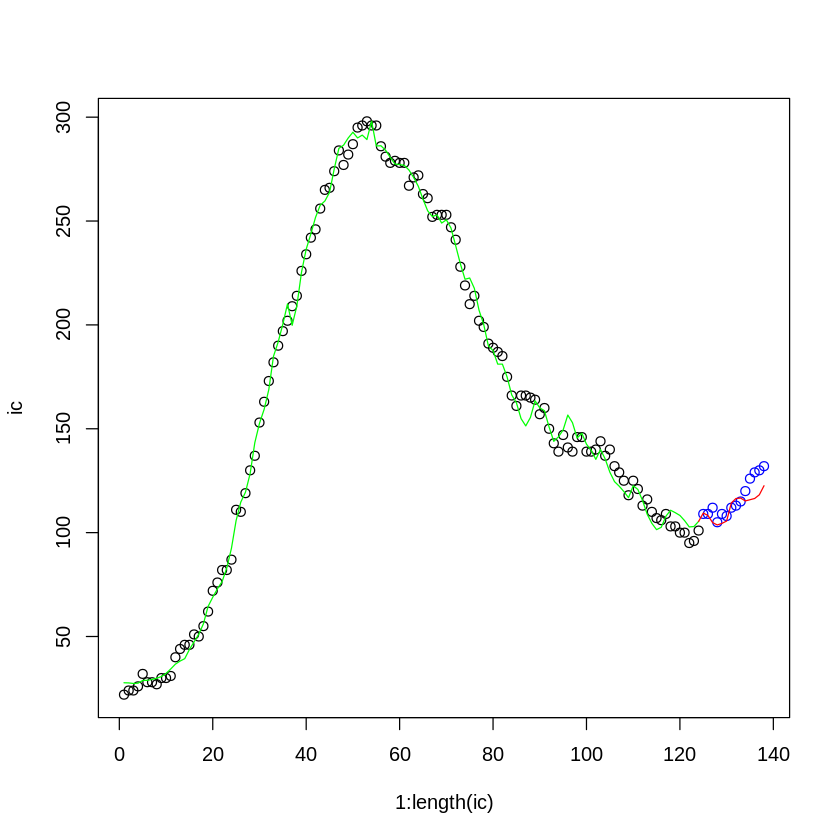

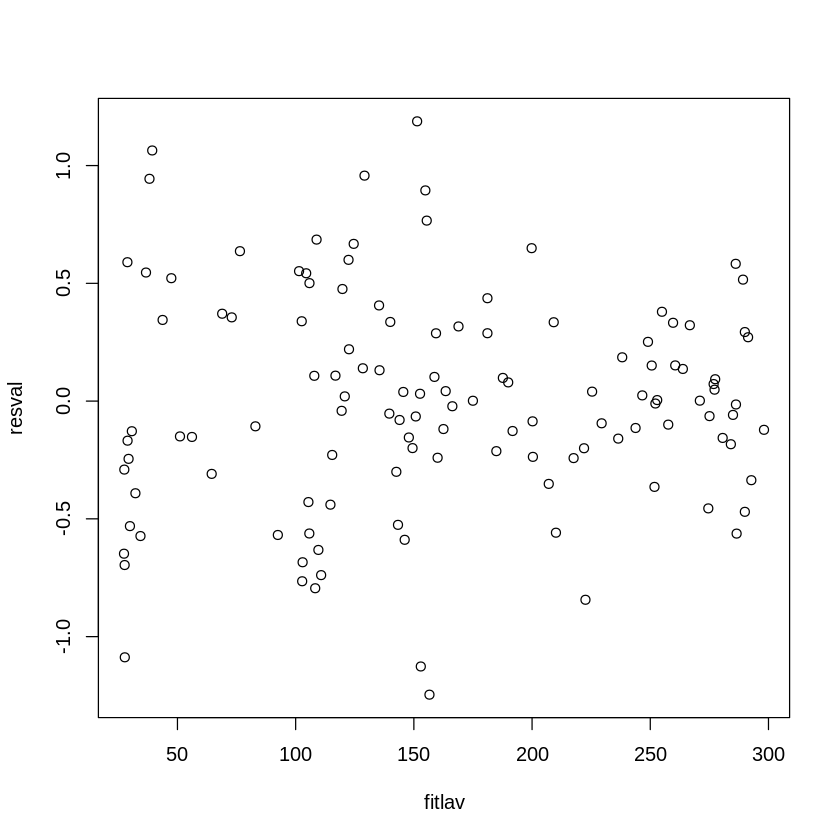

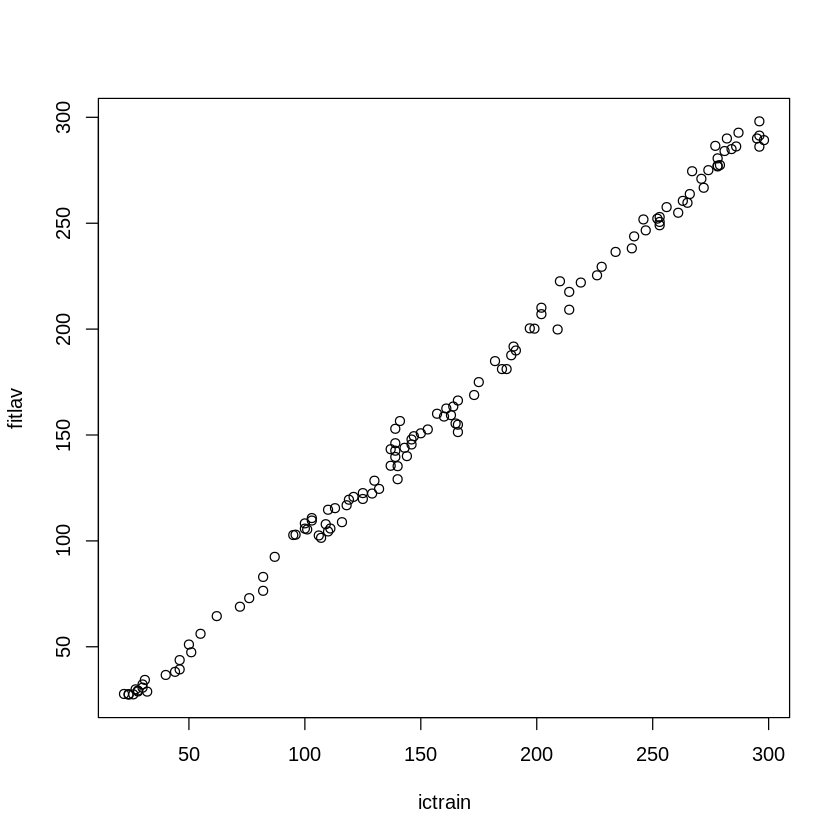

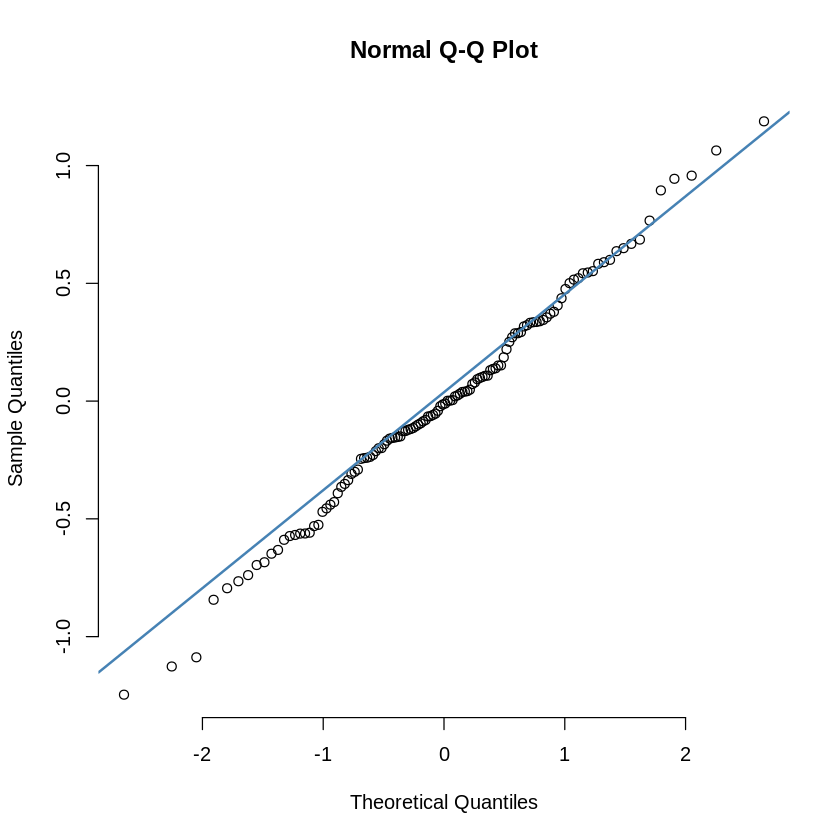

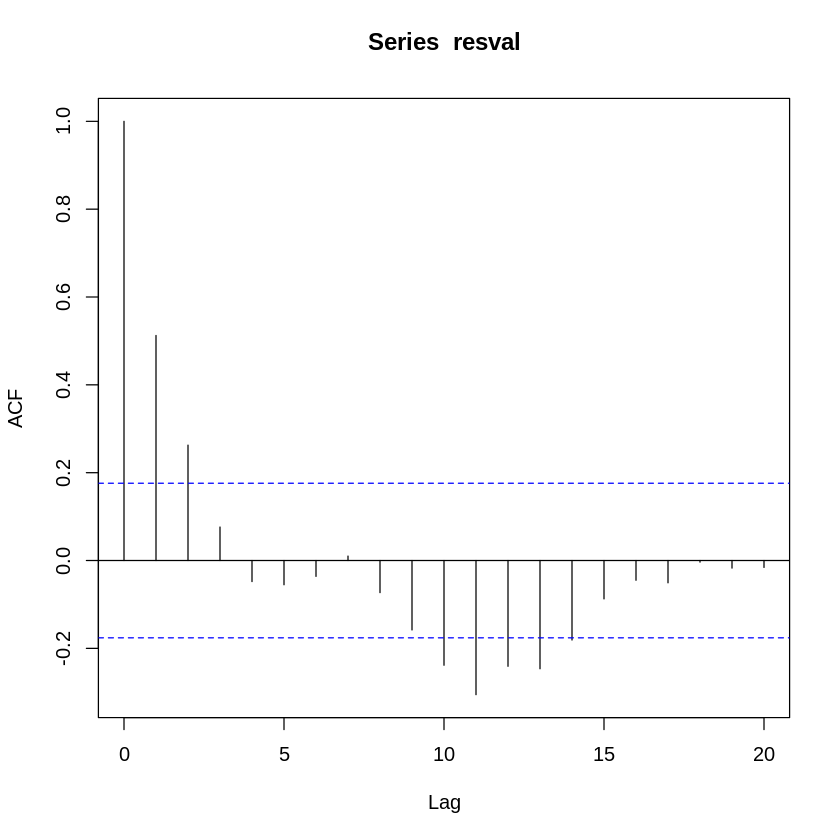

In [ ]:
#gam with epidemic separation (poisson)
library('forecast')
library('mgcv')
data<-read.csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv")
data<-data[data$denominazione_regione=="Toscana",]
datatrain<-data[221:344,]
ep=1
breakpoint=55
ep[1:breakpoint]=1
ep[(breakpoint+1):124]=0
datatest<-data[345:358,]
ictest<-datatest[,8]
ictrain=datatrain[,8]
htest<-datatest[,9]
htrain=datatrain[,9]
h1train=ep*htrain
h2train=(1-ep)*htrain
h1test=0
h1test[1:14]=0
h2test=1
h2test[1:14]=htest
timetrain<-1:length(htrain)
timetest<-(timetrain[length(timetrain)]+1):(timetrain[length(timetrain)]+length(ictest))
newdatatrain=data.frame(h1=h1train,h2=h2train,ic=ictrain)
newdatatest=data.frame(h1=h1test,h2=h2test,ic=ictest)
m3 <- gam(ic ~ s(h1, bs="ps")+s(h2, bs="ps"), family="poisson",data=newdatatrain,method = "REML")
icpred=predict(m3,newdata=newdatatest,type="response")
#plot(1:length(postrain),newpostrain)
#lines(1:length(postrain),fitted(m1))
z=0
z[1:length(timetrain)]='black'
z[(length(timetrain)+1):(length(timetrain)+length(timetest))]='blue'
ic=c(ictrain,ictest)
plot(1:length(ic), ic, col=z)
icfit=fitted(m3)
lines(1:length(timetrain),icfit,col='green')
icpred2=c(icfit[length(icfit)],icpred)
lines((length(timetrain)):(length(timetrain)+length(timetest)),icpred2,col='red')
AIC(m3)
resval=residuals(m3,type='scaled.pearson')
fitlav=fitted(m3)
plot(fitlav,resval)
plot(ictrain,fitlav)
qqnorm(resval, pch = 1, frame = FALSE)
qqline(resval, col = "steelblue", lwd = 2)
acf(resval)
#testDispersion(m3,type="PearsonChisq",refit = 'T')
#sqrt(sum((newpospred-newpostest)^2))
#auto.arima(resval)


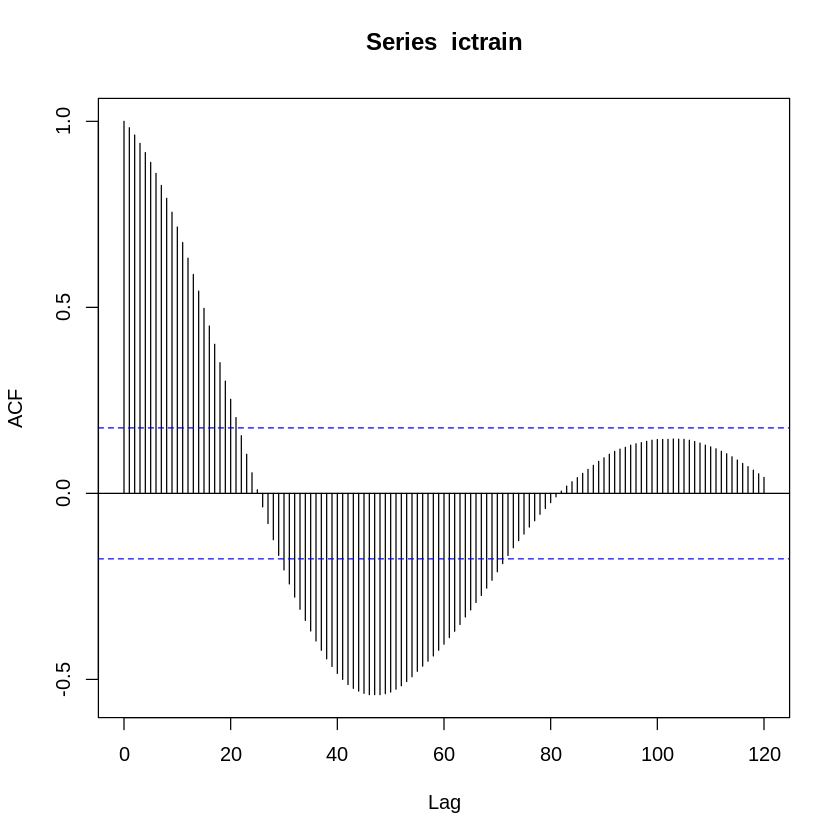


Call:
arima(x = ictrain, order = c(3, 0, 2))

Coefficients:
         ar1     ar2      ar3     ma1      ma2  intercept
      1.0129  0.9573  -0.9763  0.0422  -0.9207   165.9796
s.e.  0.1735  0.3457   0.1728  0.1860   0.1768    11.3034

sigma^2 estimated as 23.66:  log likelihood = -375.93,  aic = 765.86

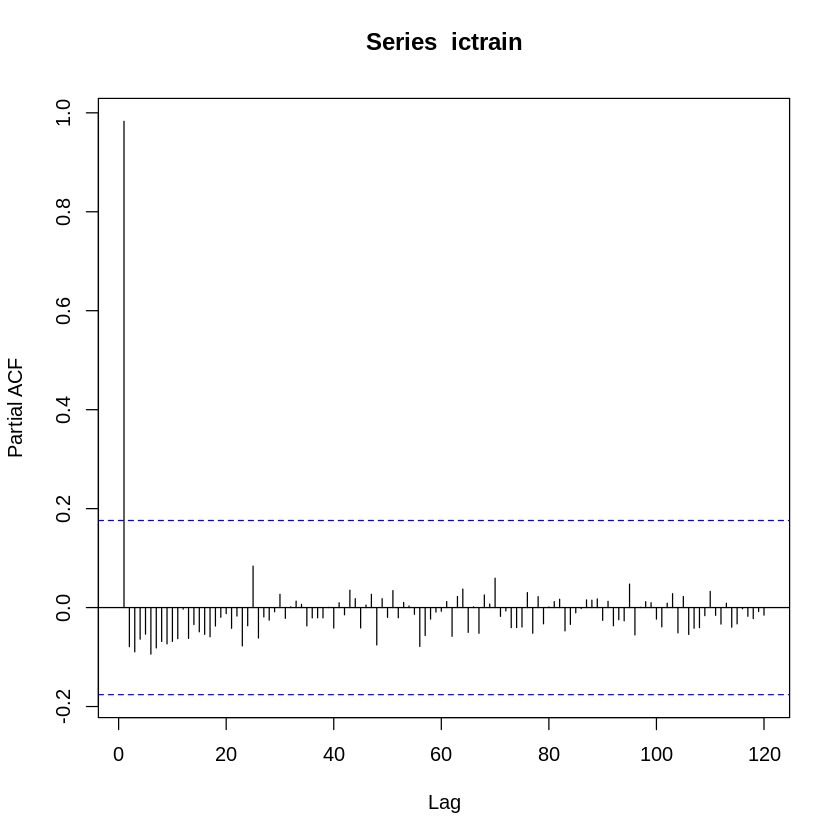

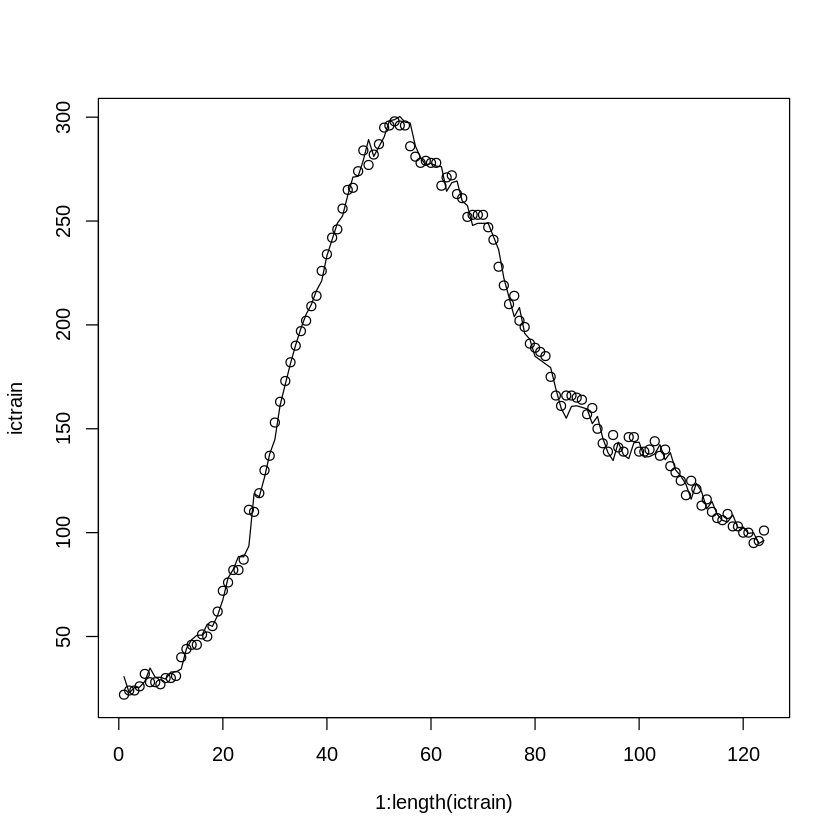

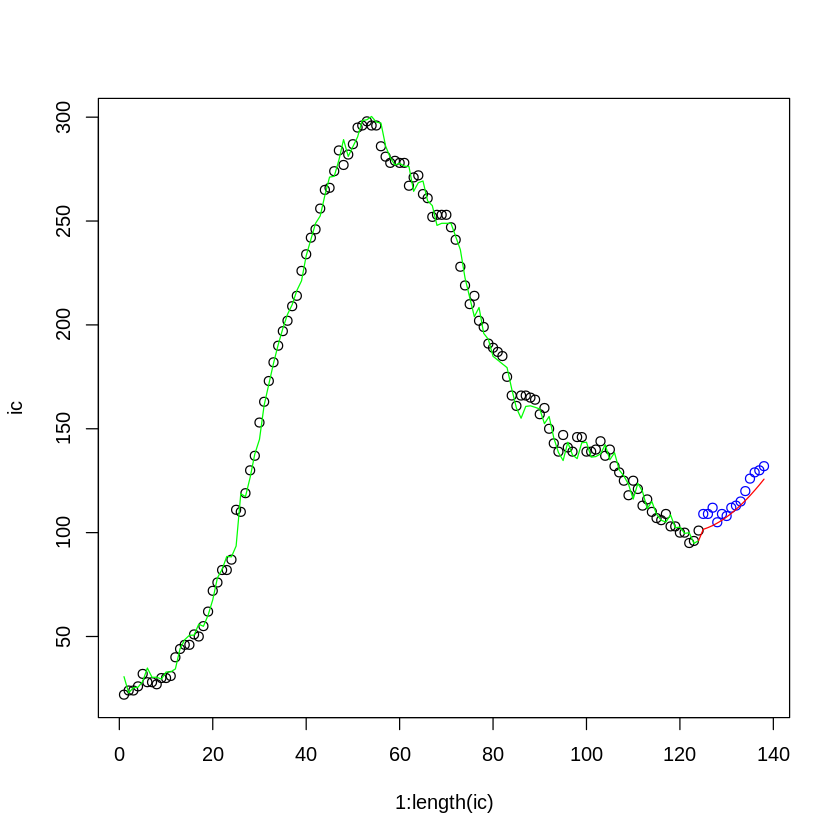

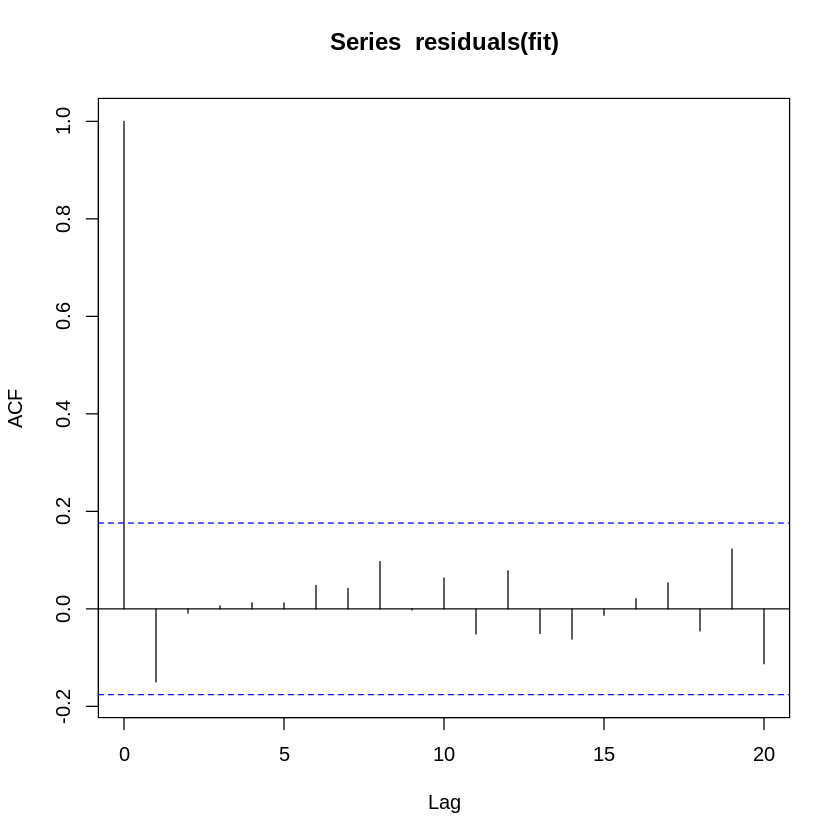

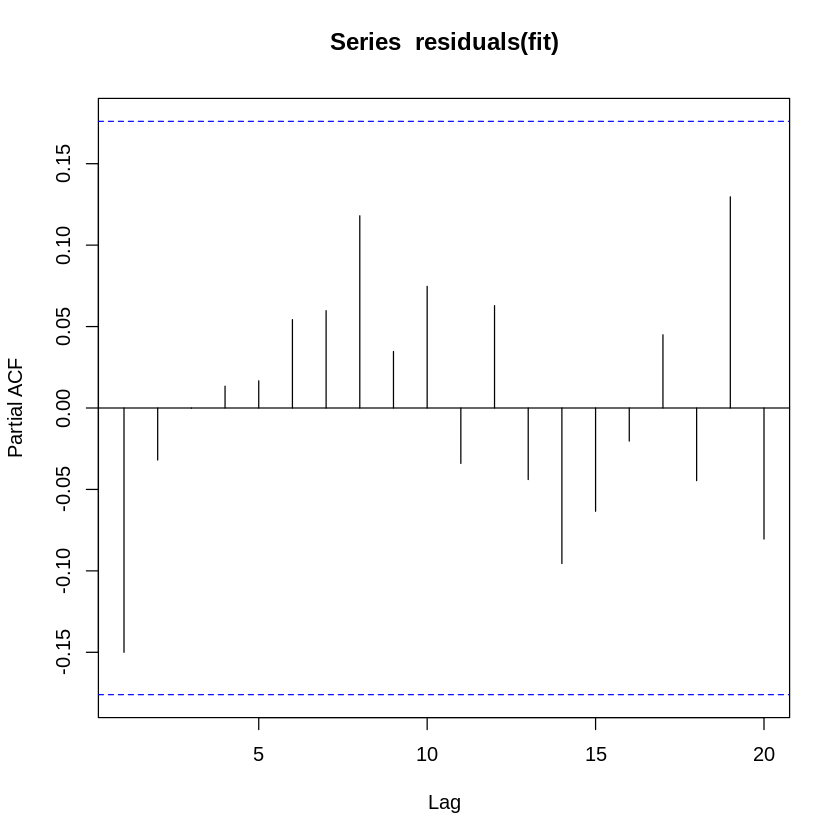

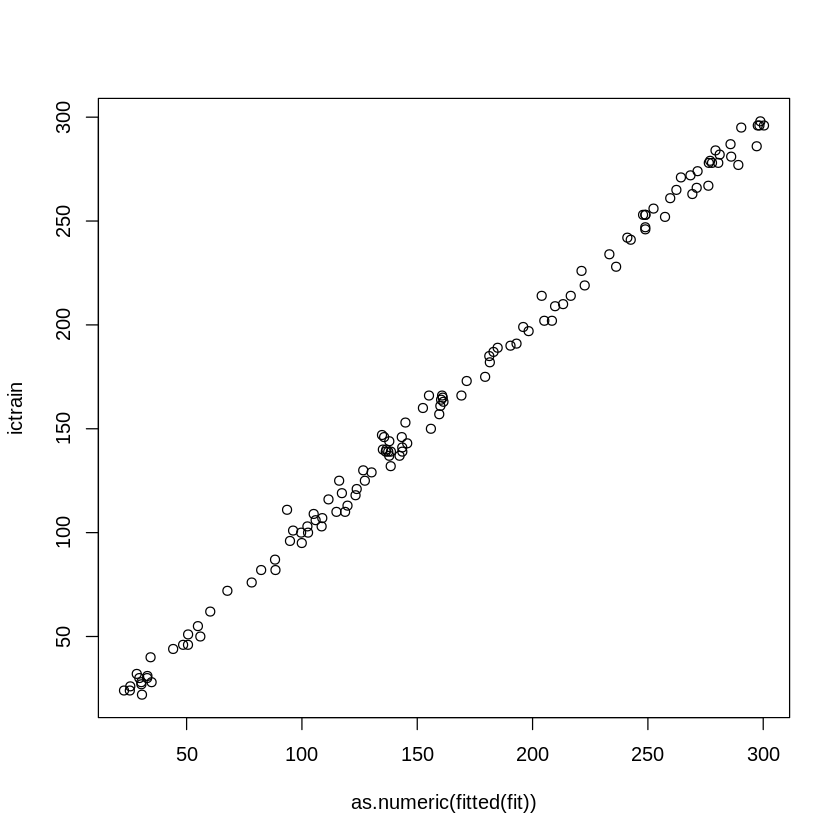

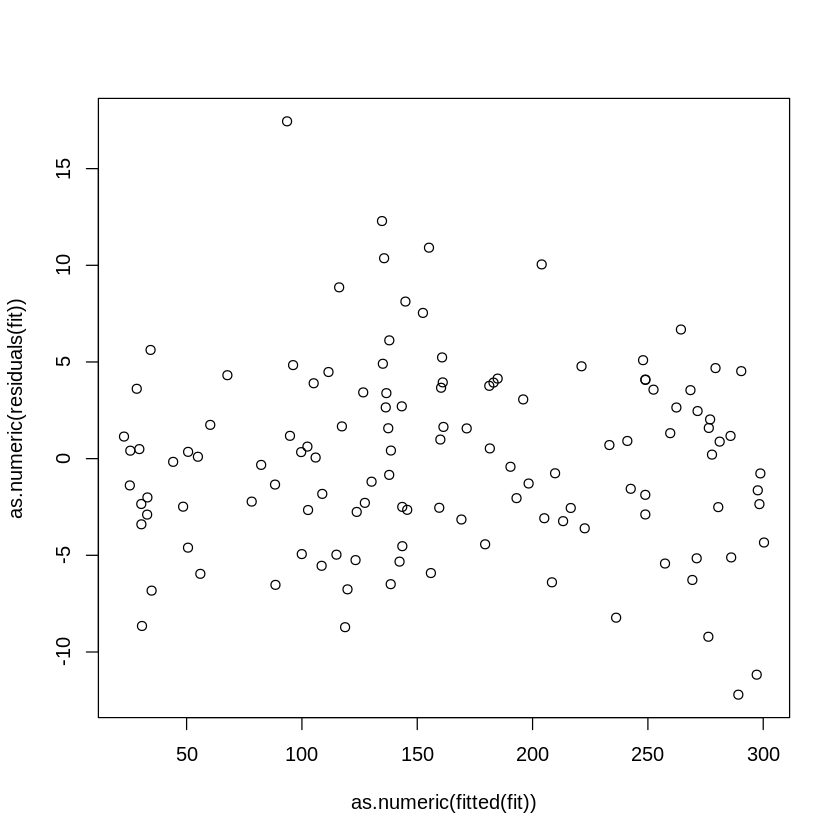

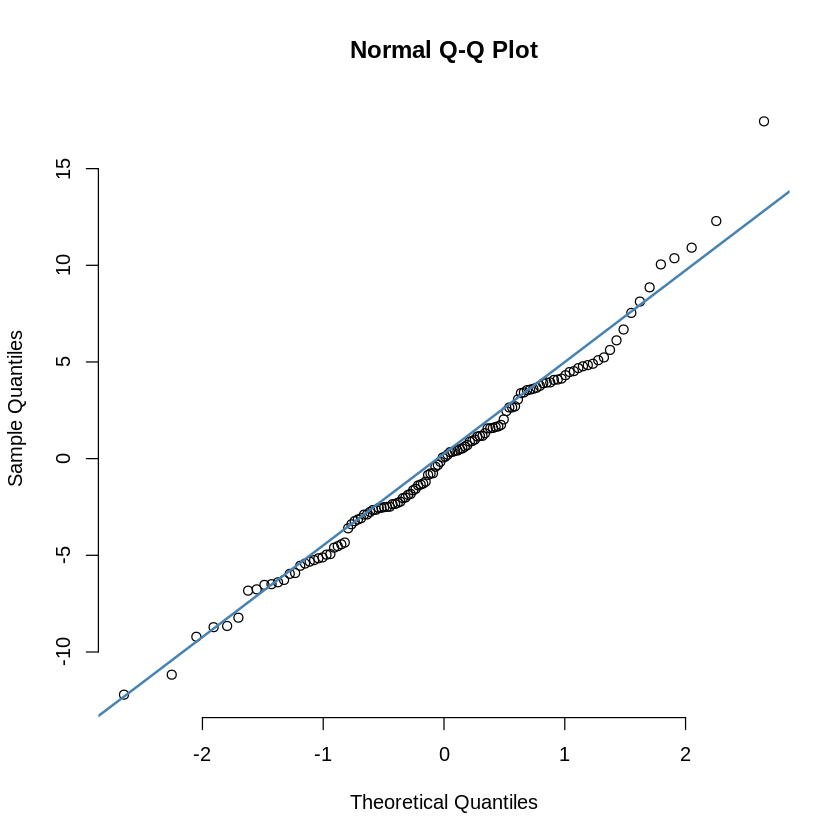

In [ ]:
#ARIMA with no external regressors
library('forecast')
data<-read.csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv")
data<-data[data$denominazione_regione=="Toscana",]
datatrain<-data[221:344,]
ep=1
breakpoint=55
ep[1:breakpoint]=1
ep[(breakpoint+1):124]=0
datatest<-data[345:358,]
ictest<-datatest[,8]
ictrain=datatrain[,8]
htest<-datatest[,9]
htrain=datatrain[,9]
h1train=ep*htrain
h2train=(1-ep)*htrain
h1test=0
h1test[1:14]=0
h2test=1
h2test[1:14]=htest
acf(ictrain,120)
pacf(ictrain,120)
fit <- arima(ictrain, order=c(3,0,2)) 
fit
plot(1:length(ictrain),ictrain)
lines(1:length(ictrain),fitted(fit))
icpred=predict(fit,n.ahead=14)$pred
z=0
z[1:length(timetrain)]='black'
z[(length(timetrain)+1):(length(timetrain)+length(timetest))]='blue'
ic=c(ictrain,ictest)
plot(1:length(ic), ic, col=z)
icfit=fitted(fit)
lines(1:length(timetrain),icfit,col='green')
icpred2=c(icfit[length(icfit)],icpred)
lines((length(timetrain)):(length(timetrain)+length(timetest)),icpred2,col='red')
acf(residuals(fit))
pacf(residuals(fit))
plot(as.numeric(fitted(fit)),ictrain)
plot(as.numeric(fitted(fit)),as.numeric(residuals(fit)))
qqnorm(as.numeric(residuals(fit)), pch = 1, frame = FALSE)
qqline(as.numeric(residuals(fit)), col = "steelblue", lwd = 2)


Series: ictrain 
Regression with ARIMA(1,1,2) errors 

Coefficients:
         ar1      ma1     ma2    xreg
      0.9633  -1.2283  0.3332  0.0837
s.e.  0.0292   0.1105  0.0980  0.0159

sigma^2 estimated as 21.33:  log likelihood=-361
AIC=732.01   AICc=732.52   BIC=746.07

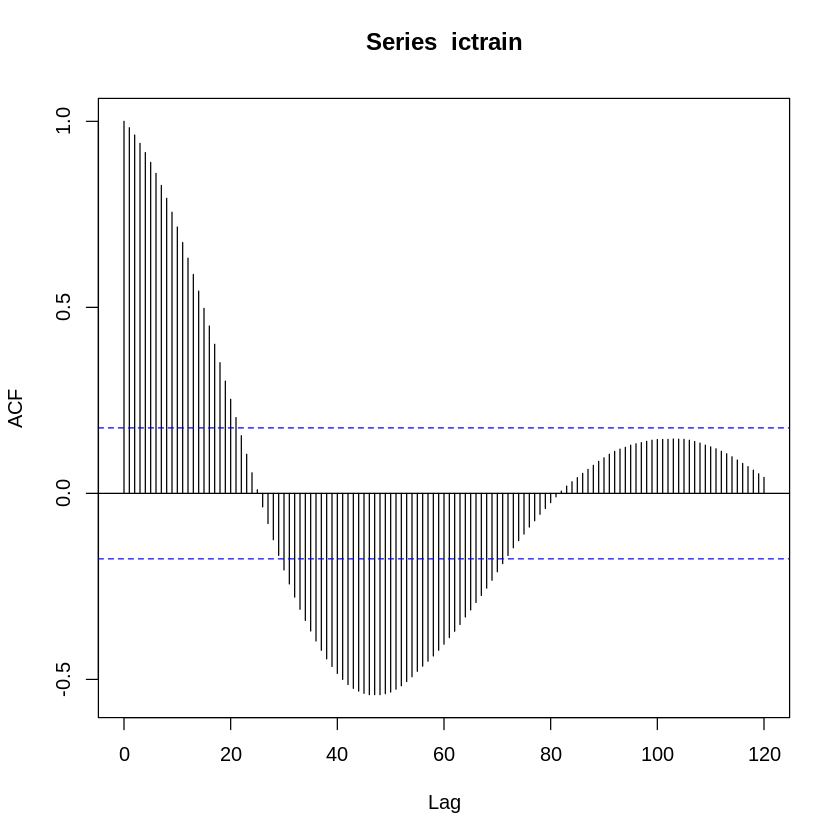

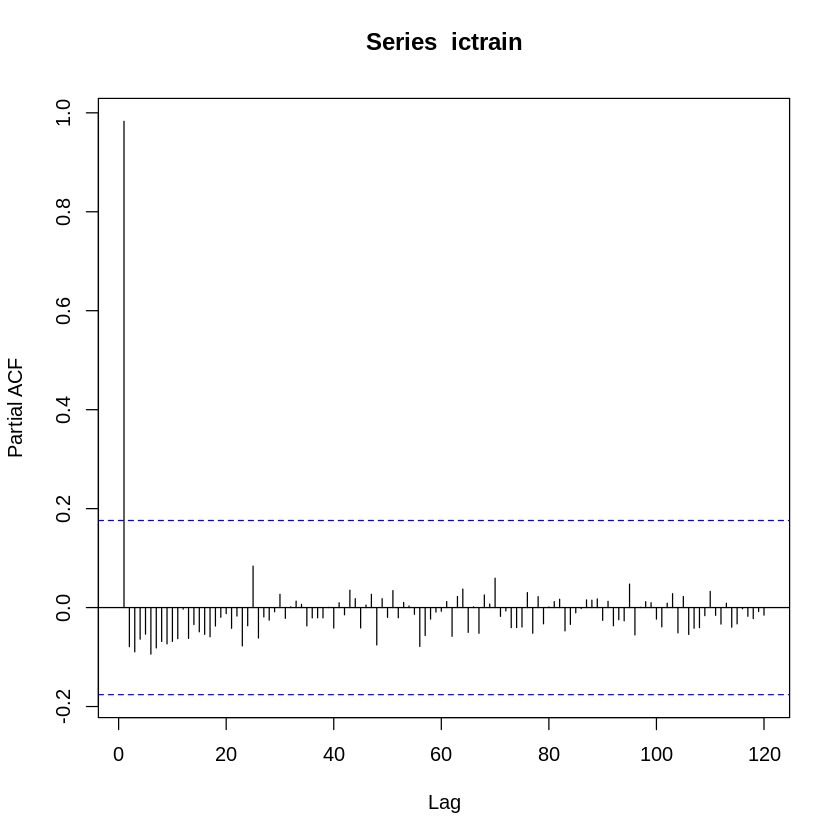

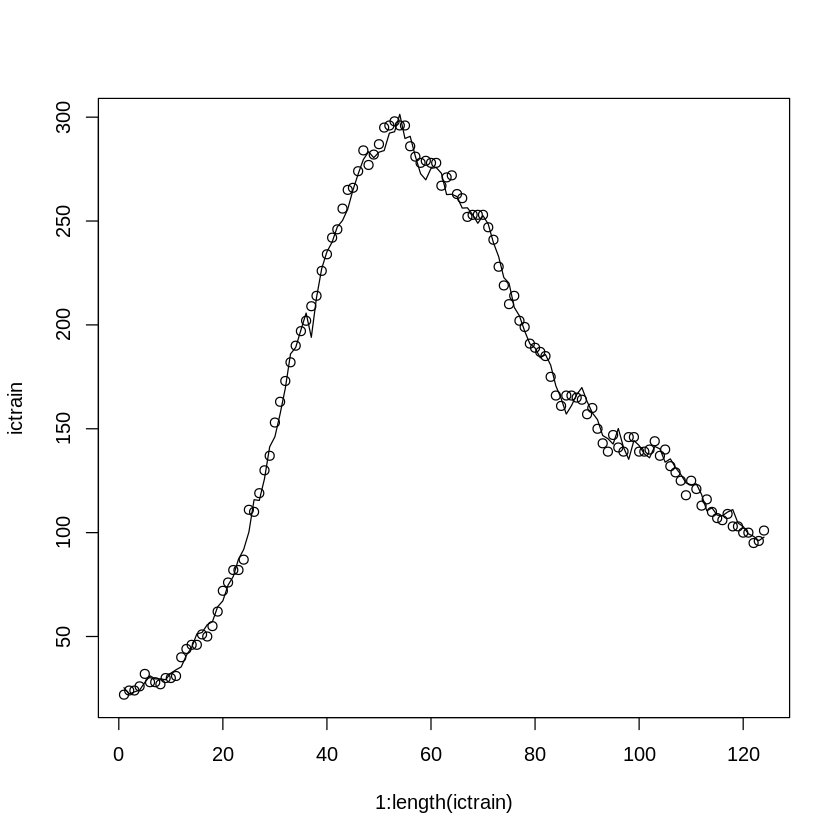

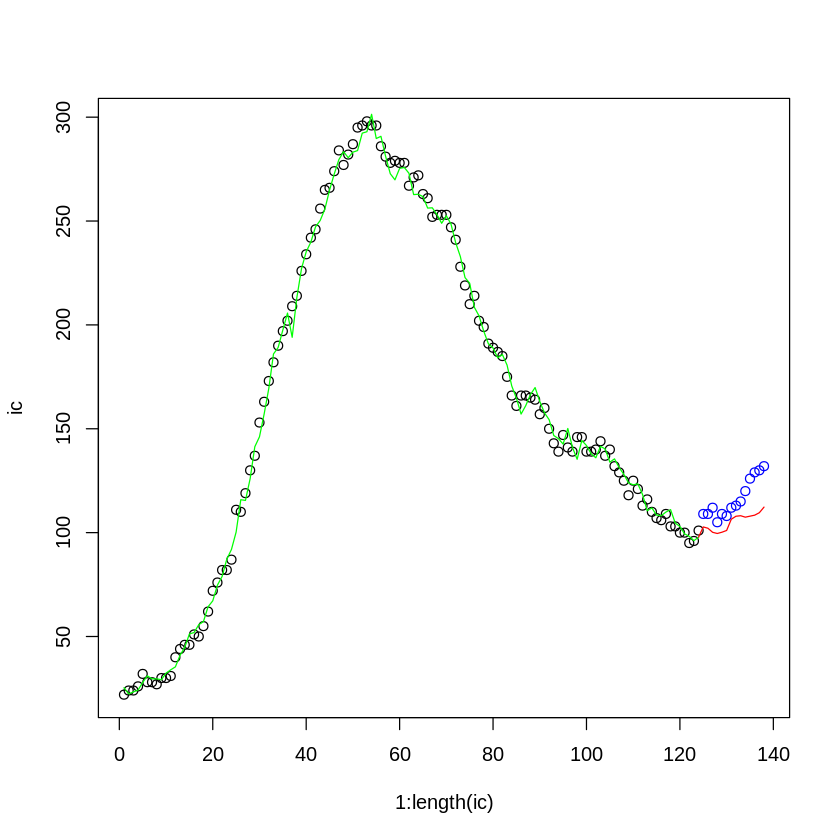

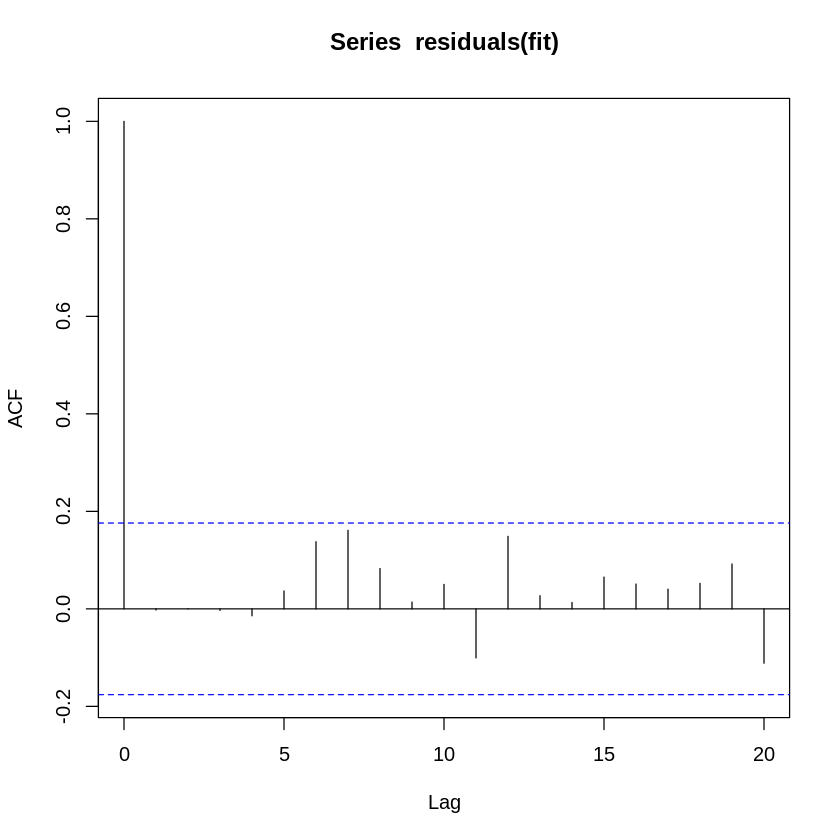

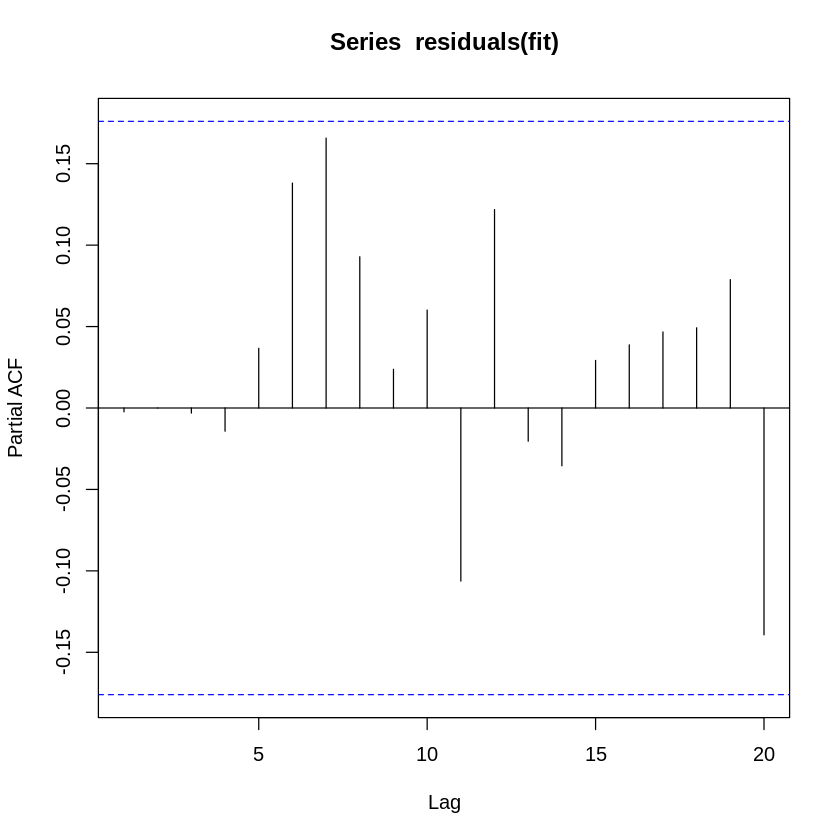

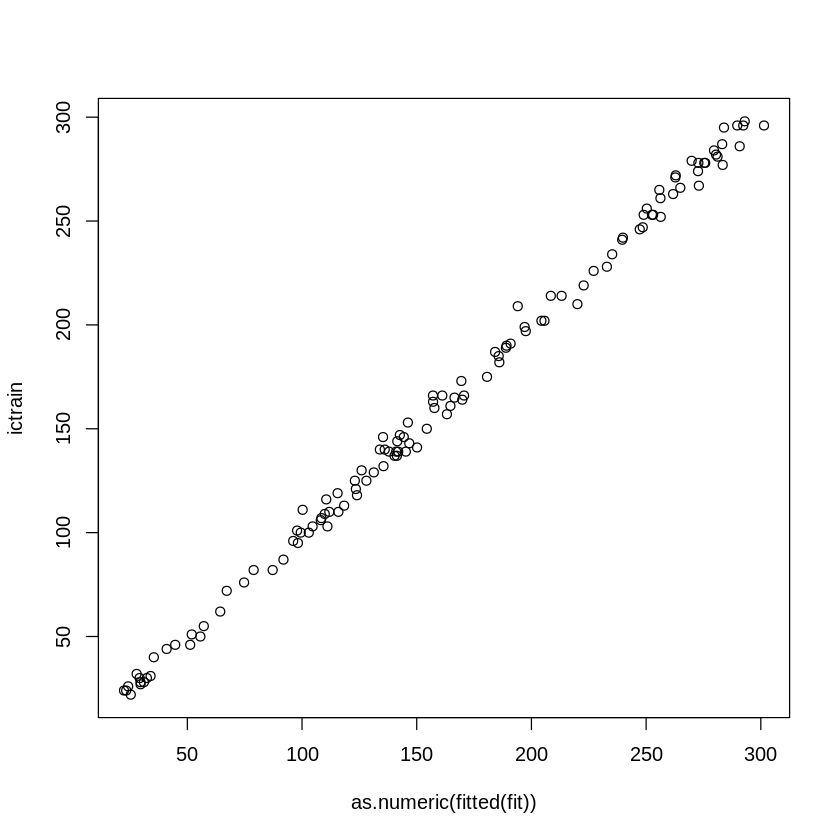

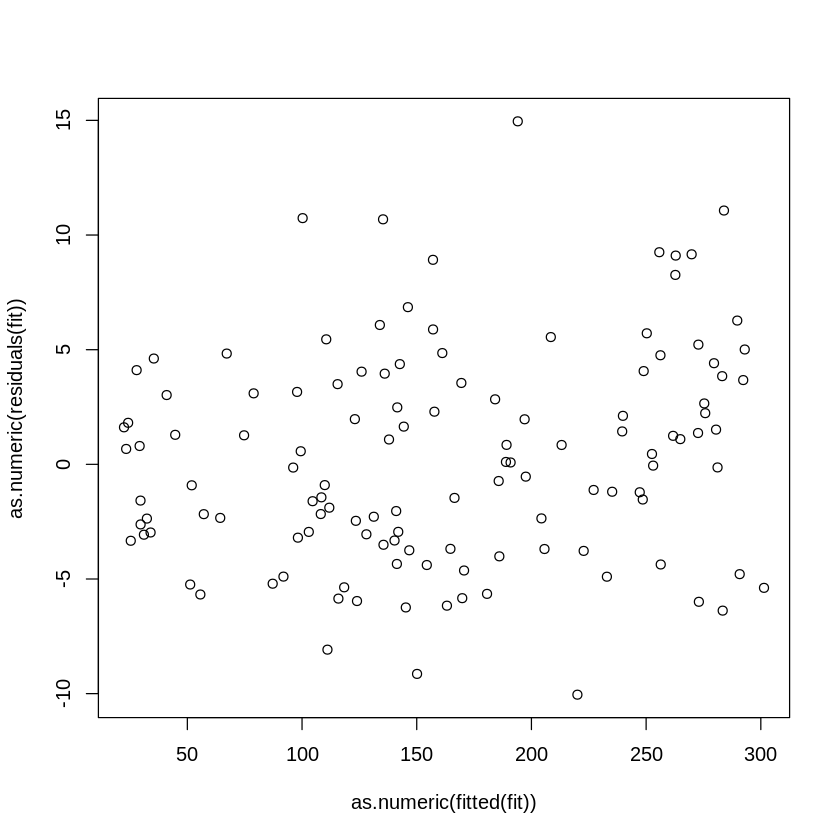

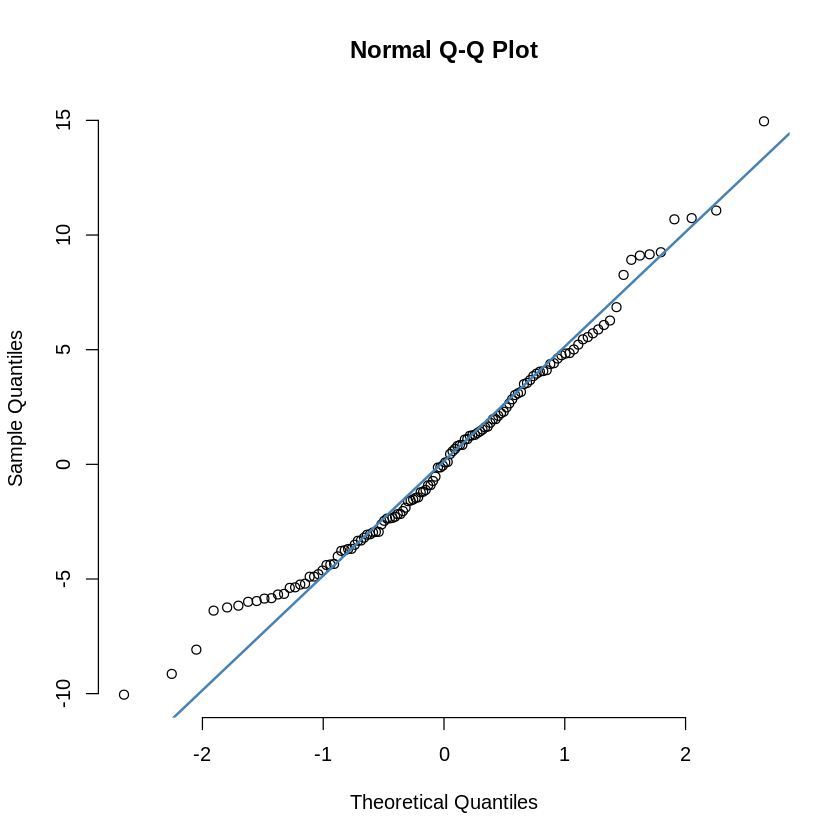

In [ ]:
#arima external regressors
library('forecast')
data<-read.csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv")
data<-data[data$denominazione_regione=="Toscana",]
datatrain<-data[221:344,]
ep=1
breakpoint=55
ep[1:breakpoint]=1
ep[(breakpoint+1):124]=0
datatest<-data[345:358,]
ictest<-datatest[,8]
ictrain=datatrain[,8]
htest<-datatest[,9]
htrain=datatrain[,9]
h1train=ep*htrain
h2train=(1-ep)*htrain
auto.arima(ictrain, xreg=htrain)
h1test=0
h1test[1:14]=0
h2test=1
h2test[1:14]=htest
acf(ictrain,120)
pacf(ictrain,120)
fit <- arima(ictrain, order=c(2,0,2),xreg=htrain)
plot(1:length(ictrain),ictrain)
lines(1:length(ictrain),fitted(fit))
icpred=predict(fit,n.ahead=14,newxreg=htest)$pred
z=0
z[1:length(timetrain)]='black'
z[(length(timetrain)+1):(length(timetrain)+length(timetest))]='blue'
ic=c(ictrain,ictest)
plot(1:length(ic), ic, col=z)
icfit=fitted(fit)
lines(1:length(timetrain),icfit,col='green')
icpred2=c(icfit[length(icfit)],icpred)
lines((length(timetrain)):(length(timetrain)+length(timetest)),icpred2,col='red')
acf(residuals(fit))
pacf(residuals(fit))
plot(as.numeric(fitted(fit)),ictrain)
plot(as.numeric(fitted(fit)),as.numeric(residuals(fit)))
qqnorm(as.numeric(residuals(fit)), pch = 1, frame = FALSE)
qqline(as.numeric(residuals(fit)), col = "steelblue", lwd = 2)




 Maximum number of PQL iterations:  20 


iteration 1

iteration 2

iteration 3

iteration 4



[1] 14

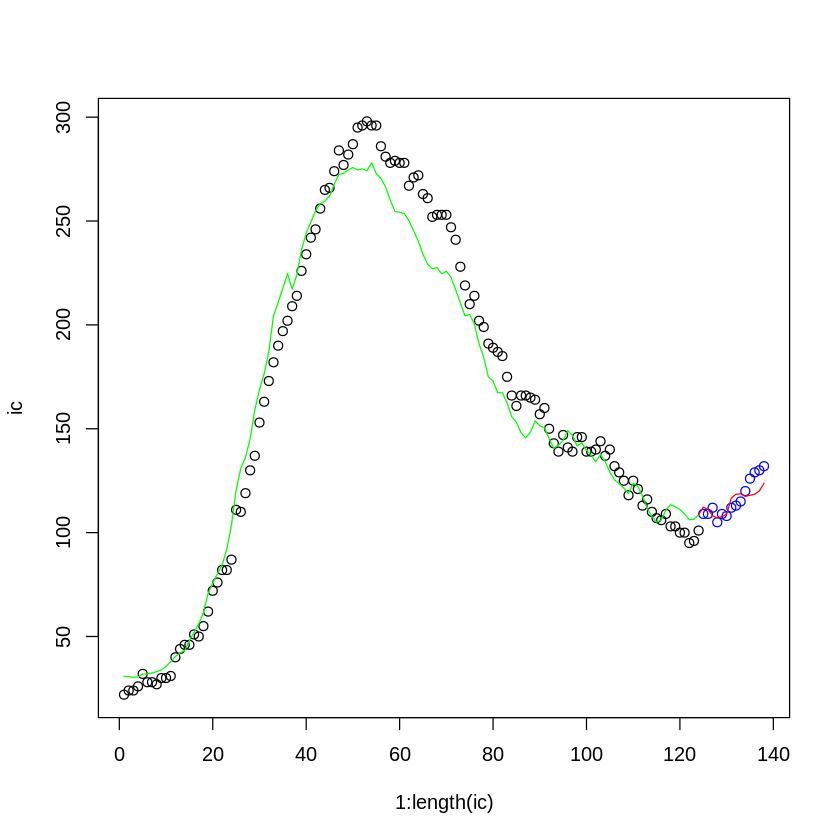

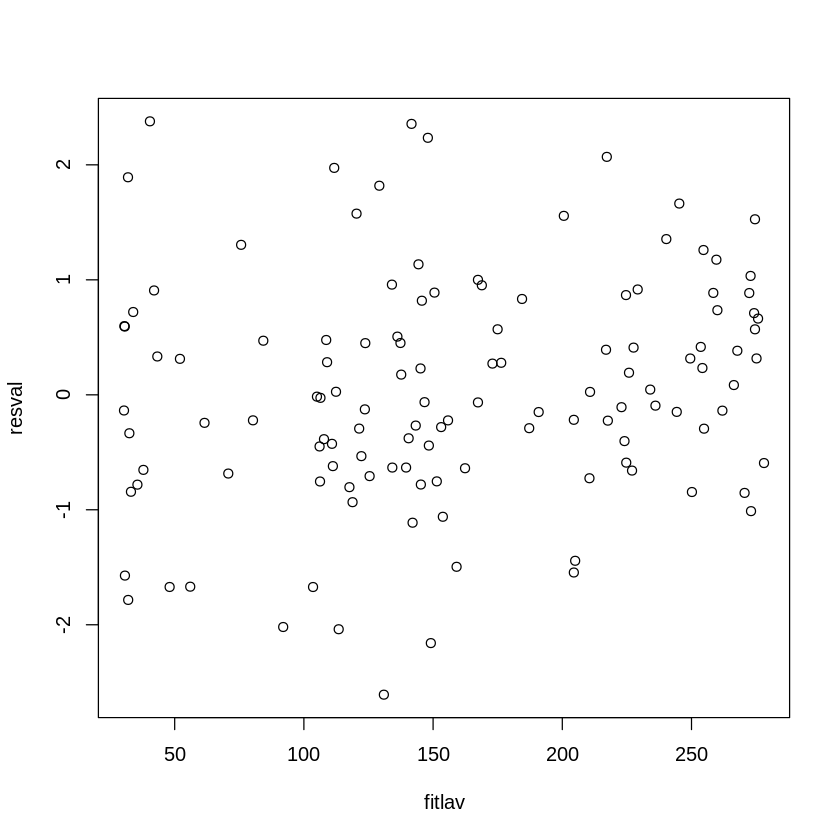

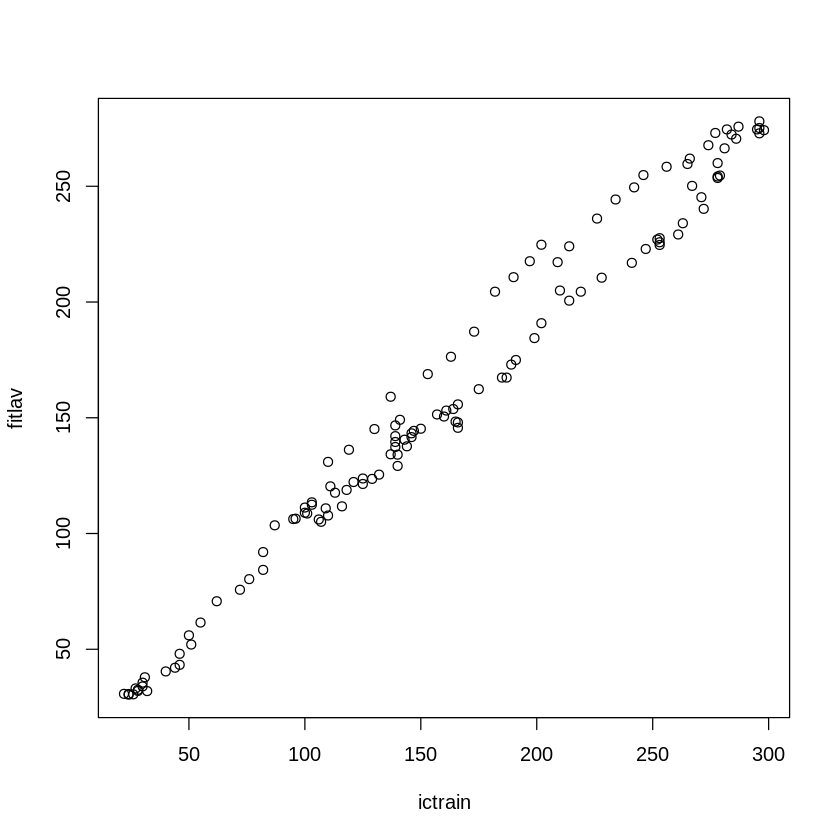

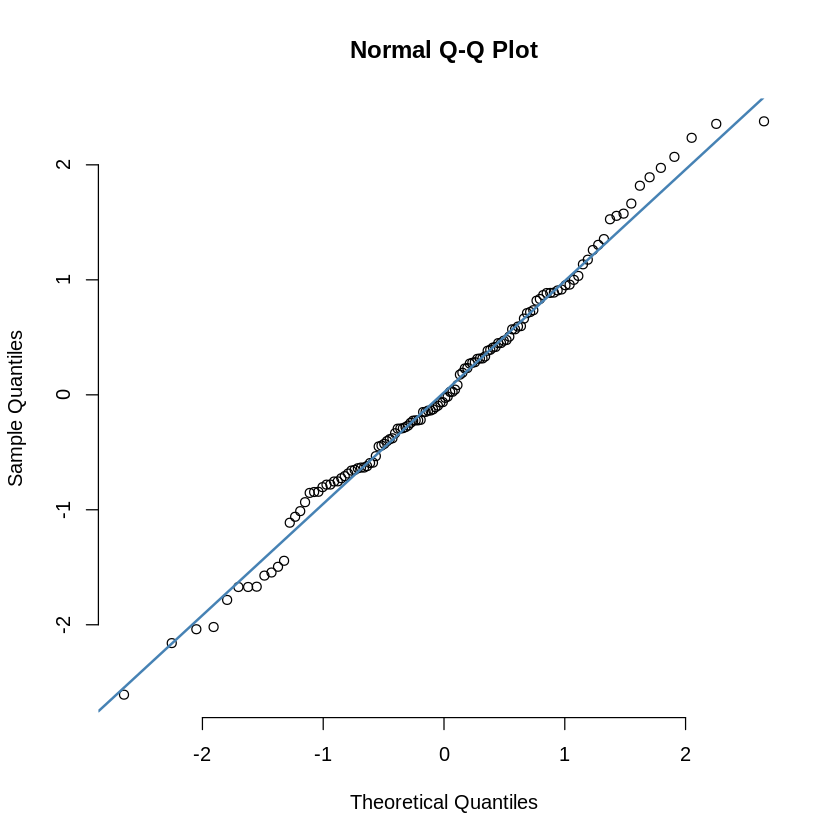


Family: poisson 
Link function: log 

Formula:
ic ~ s(h, bs = "cr")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.91299    0.03605   136.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
       edf Ref.df     F p-value    
s(h) 5.608  5.608 58.57  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.972   
  Scale est. = 1         n = 124

numeric(0)

chisq       ratio         rdf           p 
129.9084091   1.1066187 117.3922037   0.2025222

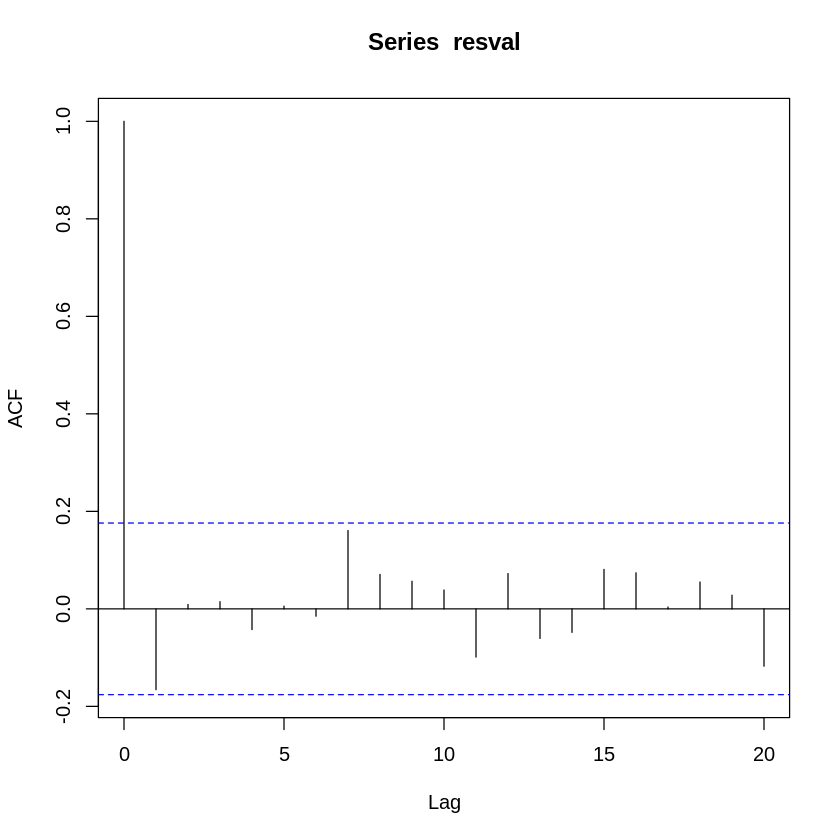

In [ ]:
#gamm without epidemic separation (poisson)
library('mgcv')
timetrain<-1:124
timetest=125:138
data<-read.csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv")
data<-data[data$denominazione_regione=="Toscana",]
datatrain<-data[221:344,]
datatest<-data[345:358,]
ictest<-datatest[,8]
ictrain=datatrain[,8]
htest<-datatest[,9]
htrain=datatrain[,9]
newdatatrain=data.frame(h=htrain,ic=ictrain)
newdatatest=data.frame(h=htest,ic=ictest)
m3 <- gamm(ic ~ s(h, bs="cr"), family="poisson",data=newdatatrain,correlation = corARMA(form=~1, p=1,q=0),method = "REML")
icpred=predict(m3$gam,newdata=newdatatest,type="response")
length(icpred)
#plot(1:length(postrain),newpostrain)
#lines(1:length(postrain),fitted(m1))
z=0
z[1:length(timetrain)]='black'
z[(length(timetrain)+1):(length(timetrain)+length(timetest))]='blue'
ic=c(ictrain,ictest)
plot(1:length(ic), ic, col=z)
icfit=fitted(m3$gam)
lines(1:length(timetrain),icfit,col='green')
icpred2=c(icfit[length(icfit)],icpred)
lines((length(timetrain)):(length(timetrain)+length(timetest)),icpred2,col='red')
resval=residuals(m3$lme,type = "normalized")
fitlav=fitted(m3$gam)
plot(fitlav,resval)
plot(ictrain,fitlav)
qqnorm(resval, pch = 1, frame = FALSE)
qqline(resval, col = "steelblue", lwd = 2)
acf(resval)
summary(m3$gam)
AIC(m3$gam)
overdisp_fun(m3$gam)
#sqrt(sum((newpospred-newpostest)^2))


 Maximum number of PQL iterations:  20 


iteration 1

iteration 2

iteration 3

iteration 4



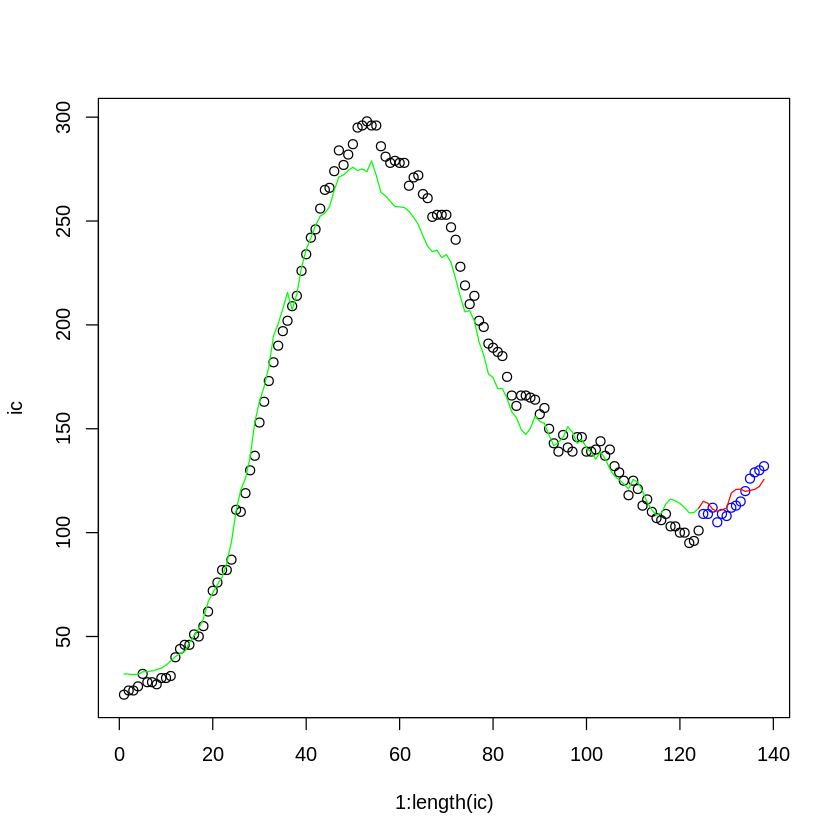

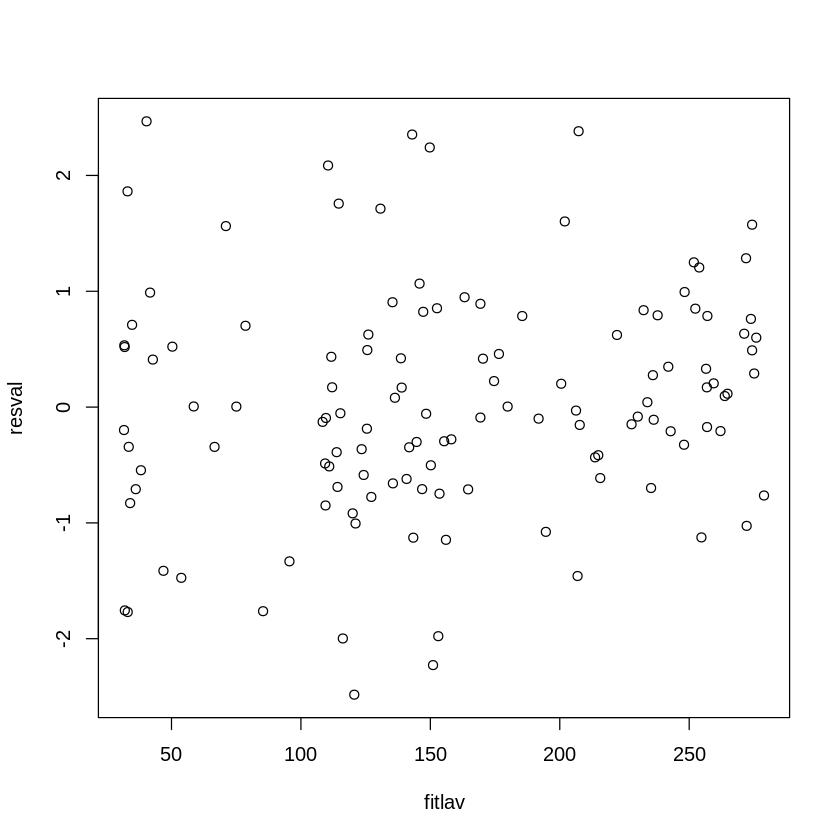

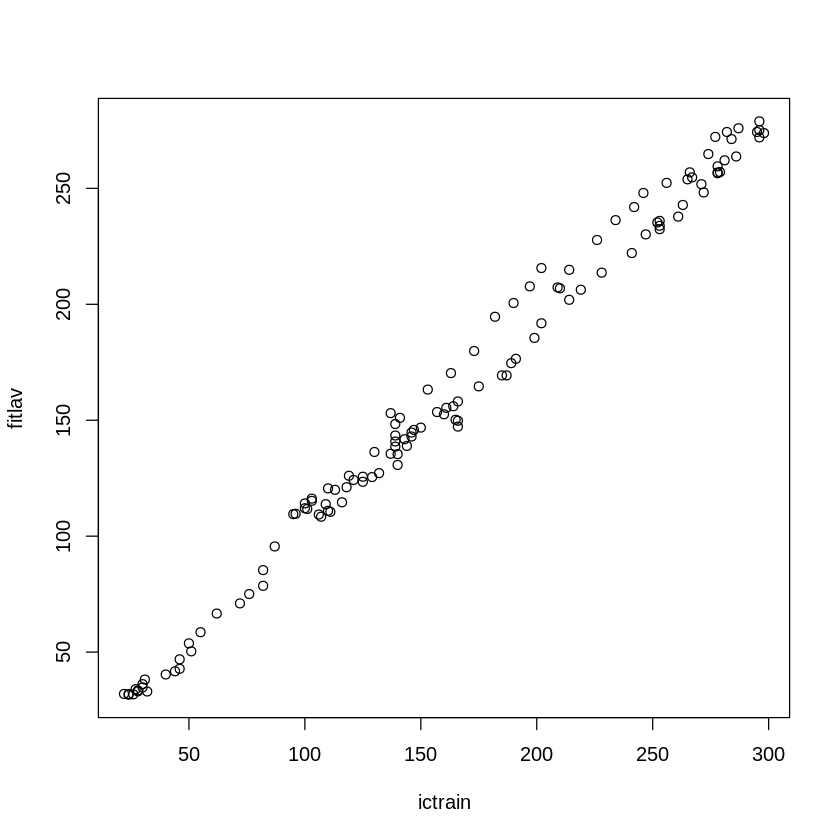

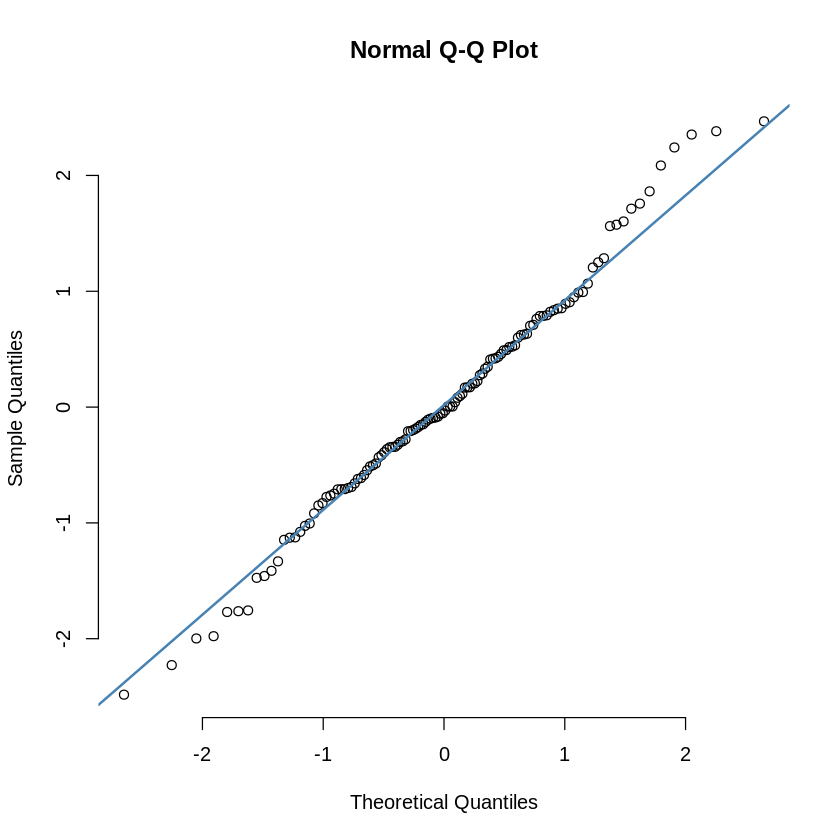


Family: poisson 
Link function: log 

Formula:
ic ~ s(h1, bs = "ps") + s(h2, bs = "ps")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.91250    0.03579   137.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
        edf Ref.df     F p-value    
s(h1) 3.955  3.955 63.91  <2e-16 ***
s(h2) 3.890  3.890 66.87  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.981   
  Scale est. = 1         n = 124

chisq       ratio         rdf           p 
 93.4994097   0.8119428 115.1551702   0.9309709

numeric(0)

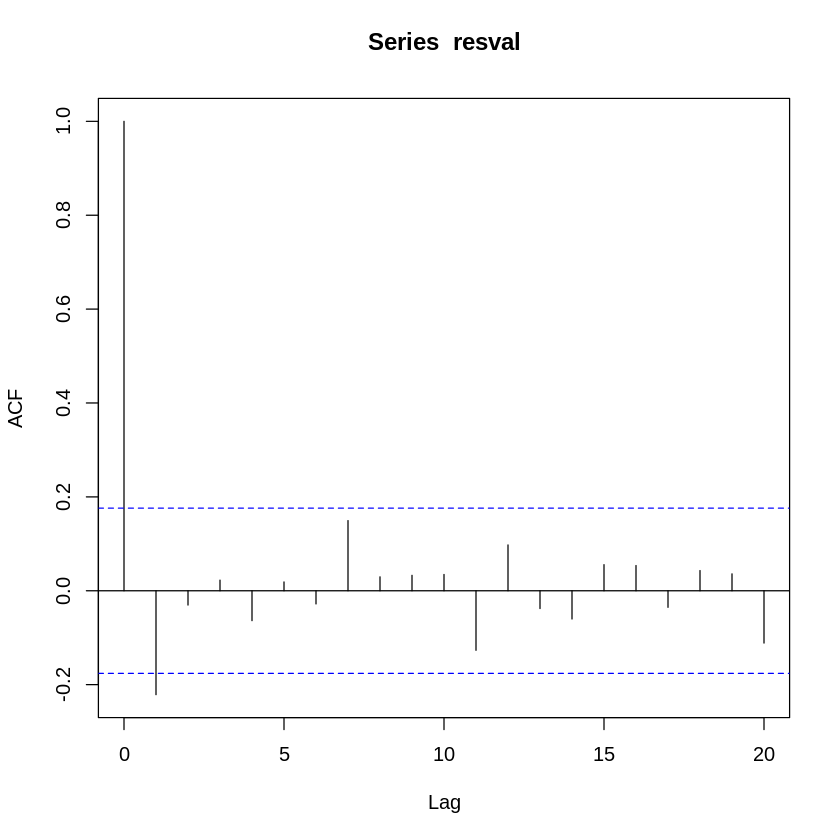

In [ ]:
#gamm with epidemic separation (poisson)
library('mgcv')
timetrain<-1:124
timetest=125:138
data<-read.csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv")
data<-data[data$denominazione_regione=="Toscana",]
datatrain<-data[221:344,]
datatest<-data[345:358,]
breakpoint=55
ep[1:breakpoint]=1
ep[(breakpoint+1):124]=0
datatest<-data[345:358,]
ictest<-datatest[,8]
ictrain=datatrain[,8]
htest<-datatest[,9]
htrain=datatrain[,9]
h1train=ep*htrain
h2train=(1-ep)*htrain
h1test=0
h1test[1:14]=0
h2test=1
h2test[1:14]=htest
ictest<-datatest[,8]
ictrain=datatrain[,8]
htest<-datatest[,9]
htrain=datatrain[,9]
newdatatrain=data.frame(h1=h1train,h2=h2train,ic=ictrain)
newdatatest=data.frame(h1=h1test,h2=h2test,ic=ictest)
m3 <- gamm(ic ~ s(h1, bs="ps")+s(h2, bs="ps"), family="poisson",data=newdatatrain,correlation = corARMA(form=~1, p=1,q=0),method = "REML")
icpred=predict(m3$gam,newdata=newdatatest,type="response")
#plot(1:length(postrain),newpostrain)
#lines(1:length(postrain),fitted(m1))
z=0
z[1:length(timetrain)]='black'
z[(length(timetrain)+1):(length(timetrain)+length(timetest))]='blue'
ic=c(ictrain,ictest)
plot(1:length(ic), ic, col=z)
icfit=fitted(m3$gam)
lines(1:length(timetrain),icfit,col='green')
icpred2=c(icfit[length(icfit)],icpred)
lines((length(timetrain)):(length(timetrain)+length(timetest)),icpred2,col='red')
resval=residuals(m3$lme,type = "normalized")
fitlav=fitted(m3$gam)
plot(fitlav,resval)
plot(ictrain,fitlav)
qqnorm(resval, pch = 1, frame = FALSE)
qqline(resval, col = "steelblue", lwd = 2)
acf(resval)
summary(m3$gam)
overdisp_fun(m3$gam)
#sqrt(sum((newpospred-newpostest)^2))

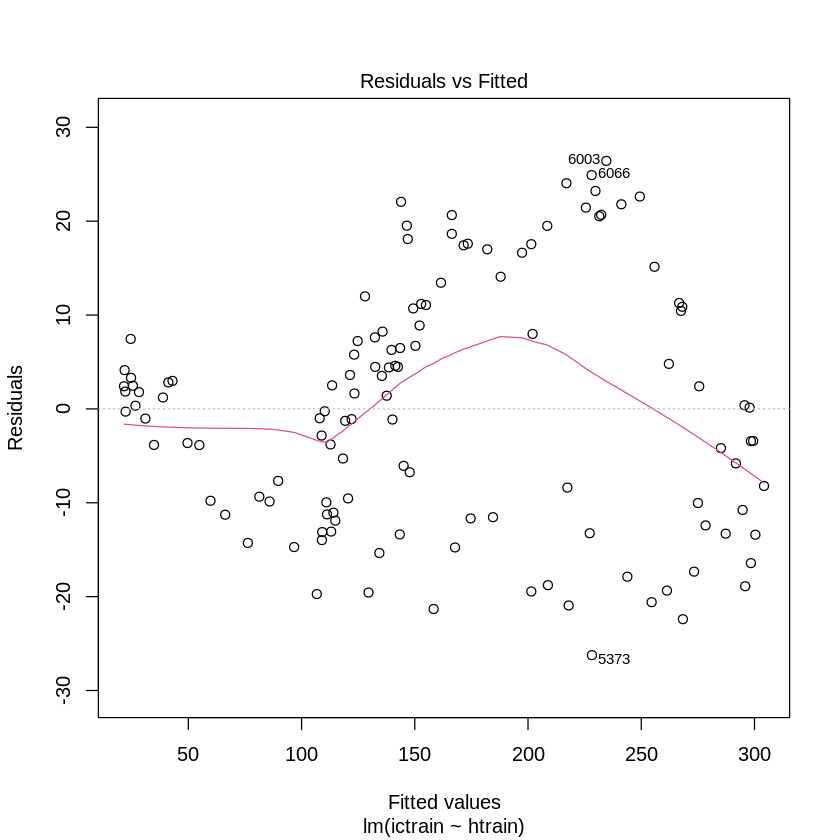

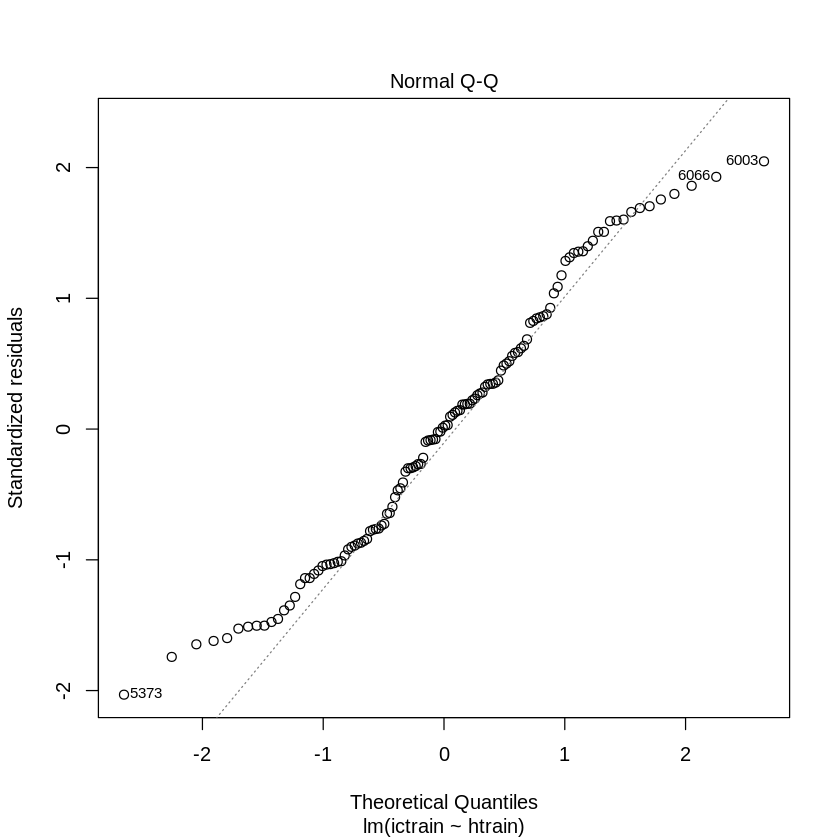

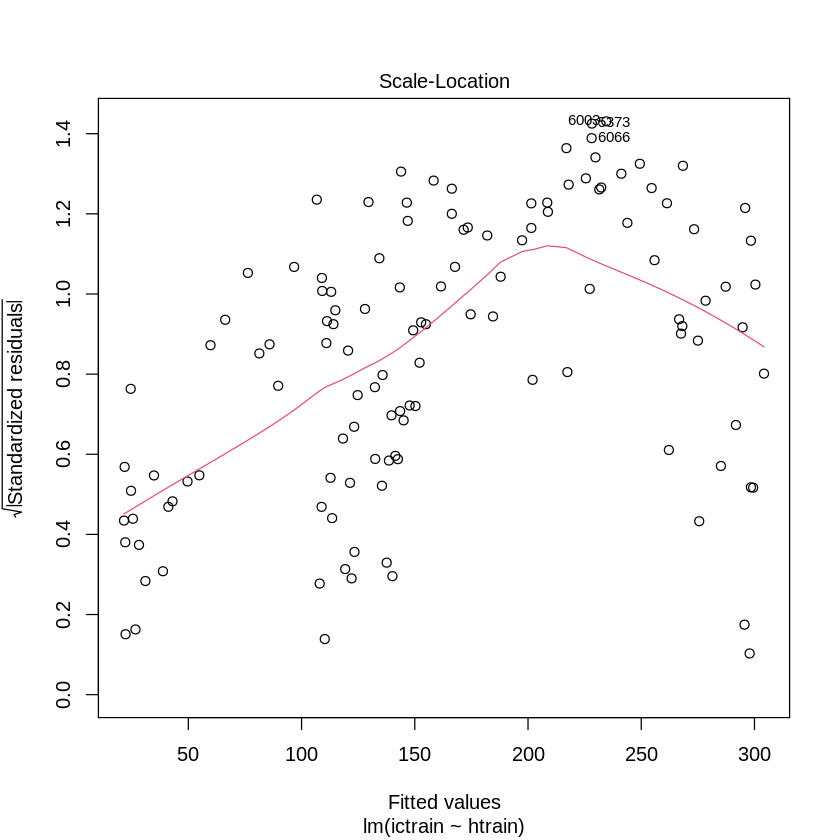


Call:
glm(formula = ictrain ~ htrain, family = "quasipoisson", data = datatrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.5467  -1.8942   0.0882   1.8422   3.2845  

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.966e+00  4.349e-02   91.19   <2e-16 ***
htrain      8.875e-04  2.883e-05   30.79   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasipoisson family taken to be 5.028985)

    Null deviance: 5673.71  on 123  degrees of freedom
Residual deviance:  662.87  on 122  degrees of freedom
AIC: NA

Number of Fisher Scoring iterations: 4


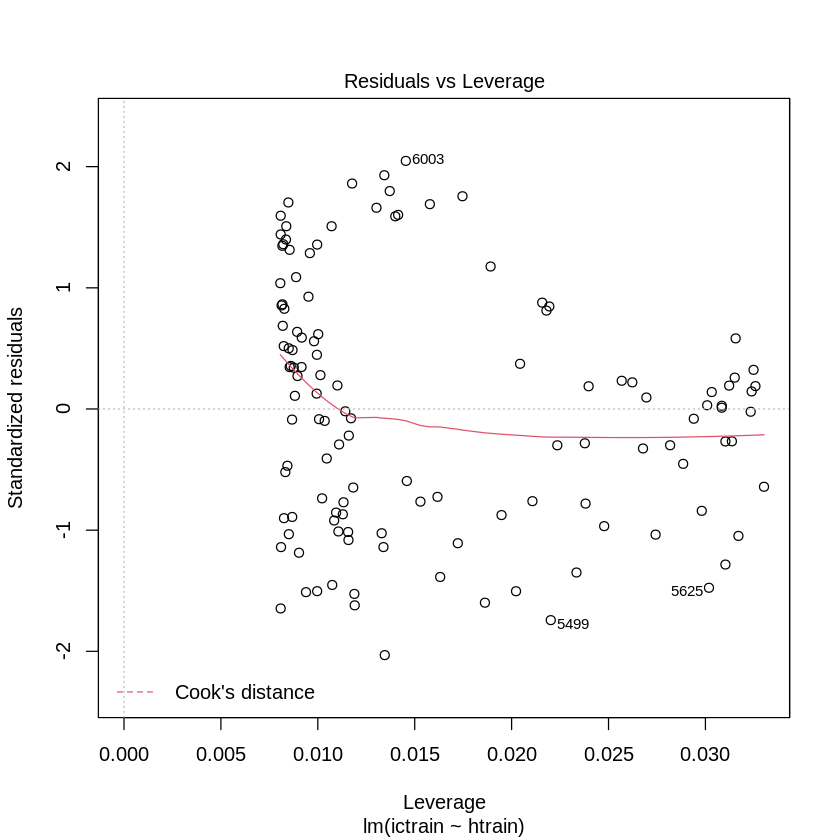

In [ ]:
data<-read.csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv")
data<-data[data$denominazione_regione=="Toscana",]
datatrain<-data[221:344,]
datatest<-data[345:358,]
ictest<-datatest[,8]
ictrain=datatrain[,8]
htest<-datatest[,9]
htrain=datatrain[,9]
mod1=lm(ictrain~htrain, data=datatrain)
mod2=glm(ictrain~htrain, data=datatrain, family='quasipoisson')


In [18]:
data<-read.csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv")
data<-data[data$denominazione_regione=="Toscana",]
data<-data[,colSums(is.na(data))==0]
datatrain<-data[221:344,]
datatest<-data[345:358,]
data<-data[,-c(2,3,4,5,6)]
data<-data[,-c(13:17)]
names(data)


[1] "data"                       "ricoverati_con_sintomi"    
 [3] "terapia_intensiva"          "totale_ospedalizzati"      
 [5] "isolamento_domiciliare"     "totale_positivi"           
 [7] "variazione_totale_positivi" "nuovi_positivi"            
 [9] "dimessi_guariti"            "deceduti"                  
[11] "totale_casi"                "tamponi"